# **Modeling and Evaluation**

## Objectives

This notebook focuses on training, optimizing, and evaluating a regression model that predicts the **sale price of houses** in Ames, Iowa. It is the core modeling step for **Business Requirement 2**, where the client wants to estimate property values based on known house attributes.

Key goals include:
- Selecting a subset of features that most strongly predict sale price
- Trying multiple regression models and choosing the most effective
- Evaluating the model using R², MAE, RMSE, and visualization
- Saving the model pipeline for deployment in the Streamlit app

## Inputs

- outputs\datasets\cleaned\TrainSetCleaned.csv
- outputs\datasets\cleaned\TestSetCleaned.csv

## Outputs

- `X_train.csv` and `X_test.csv`: Train/test sets with selected features
- `y_train.csv` and `y_test.csv`: Corresponding targets (SalePrice)
- Fitted regression pipeline (`best_regressor_pipeline.pkl`)
- Feature importance plot (`feature_importance.png`)
- Evaluation metrics and model summary


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with `os.getcwd()`

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\Arthur\\OneDrive\\Documentos\\Code Institute\\PP5\\PP5-heritage-housing-issues-ml\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* `os.path.dirname()` gets the parent directory
* `os.chir()` defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
print("New working directory set to:", os.getcwd())

New working directory set to: c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml


---

# Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/house_prices_records.csv")
      .drop(labels=['EnclosedPorch', 'WoodDeckSF'], axis=1)
  )

print(df.shape)
df.head(5)

(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


---

# ML Pipeline with all data

# Create ML Pipeline

We define a flexible and modular ML pipeline using `sklearn.pipeline`. This pipeline includes encoding, transformations, multicollinearity reduction, scaling, feature selection, and the model itself.

All transformation steps are based on decisions made in the Feature Engineering notebook, including:
- Ordinal encoding for 4 categorical features
- Log, power, and Yeo-Johnson transformations for skewed numeric features
- SmartCorrelatedSelection with threshold = 0.6

In [5]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.imputation import ArbitraryNumberImputer, MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import LogTransformer, PowerTransformer, YeoJohnsonTransformer
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

def PipelineOptimization(model):
    num_impute_zero = ['2ndFlrSF', 'MasVnrArea', 'GarageYrBlt']
    num_impute_median = ['BedroomAbvGr', 'LotFrontage']
    cat_impute_missing = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish']
    ordinal_encode = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

    yeojohnson_transform = ['BedroomAbvGr', 'GrLivArea', 'LotFrontage', 'LotArea', 'OverallCond', 'TotalBsmtSF', '1stFlrSF']
    power_transform = ['BsmtFinSF1', 'BsmtUnfSF', 'MasVnrArea', 'OpenPorchSF']

    pipeline = Pipeline([
        ("num_zero", ArbitraryNumberImputer(arbitrary_number=0, variables=num_impute_zero)),
        ("num_median", MeanMedianImputer(imputation_method='median', variables=num_impute_median)),
        ("cat_missing", CategoricalImputer(imputation_method='missing', variables=cat_impute_missing)),

        ("ordinal_encoder", OrdinalEncoder(encoding_method='arbitrary', variables=ordinal_encode)),

        ("yeojohnson", YeoJohnsonTransformer(variables=yeojohnson_transform)),
        ("power_transform", PowerTransformer(variables=power_transform)),

        ("correlation_filter", SmartCorrelatedSelection(
            method='spearman',
            threshold=0.7,
            selection_method='variance')),
        
        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),
    ])

    return pipeline


Custom Class for hyperparameter optimisation

In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Split Train Test Set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


In [8]:
X_train.head(10)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
618,1828,0.0,NaN,Av,48,NaN,1774,774,Unf,2007.0,...,Gd,11694,90.0,452.0,108,5,9,1822,2007,2007
870,894,0.0,2.0,No,0,Unf,894,308,NaN,1962.0,...,TA,6600,60.0,0.0,0,5,5,894,1962,1962
92,964,0.0,2.0,No,713,ALQ,163,432,Unf,1921.0,...,TA,13360,80.0,0.0,0,7,5,876,1921,2006
817,1689,0.0,3.0,No,1218,GLQ,350,857,RFn,2002.0,...,Gd,13265,NaN,148.0,59,5,8,1568,2002,2002
302,1541,0.0,3.0,No,0,Unf,1541,843,RFn,2001.0,...,Gd,13704,118.0,150.0,81,5,7,1541,2001,2002
1454,1221,0.0,2.0,No,410,GLQ,811,400,RFn,2004.0,...,Gd,7500,62.0,0.0,113,5,7,1221,2004,2005
40,1324,0.0,3.0,No,643,Rec,445,440,NaN,1965.0,...,TA,8658,84.0,101.0,138,5,6,1088,1965,1965
959,696,720.0,3.0,No,604,ALQ,92,484,Unf,1999.0,...,Gd,2572,24.0,0.0,44,5,7,696,1999,1999
75,526,462.0,2.0,Gd,462,GLQ,0,297,Unf,1973.0,...,TA,1596,21.0,0.0,101,5,4,462,1973,1973
1389,869,349.0,3.0,No,375,ALQ,360,440,Unf,2003.0,...,TA,6000,60.0,0.0,0,6,6,735,1941,1950


## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

### Perform Quick Hyperparameter Search

This cell uses the `HyperparameterOptimizationSearch` class to perform a quick grid search over default hyperparameters for multiple regression models. The goal is to identify the most suitable algorithm for predicting house prices. The search evaluates models using 5-fold cross-validation and the R² scoring metric. Results will help determine which model to focus on for further optimization.

In [10]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [11]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.655194,0.789905,0.850452,0.070933
0,LinearRegression,0.733106,0.789001,0.832841,0.038104
2,RandomForestRegressor,0.688822,0.771005,0.817627,0.047467
5,GradientBoostingRegressor,0.611777,0.758846,0.820802,0.075596
4,AdaBoostRegressor,0.670232,0.748495,0.774827,0.039446
6,XGBRegressor,0.516448,0.645533,0.751455,0.08446
1,DecisionTreeRegressor,0.494971,0.579547,0.667303,0.063698


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [12]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "LinearRegression": LinearRegression(),
}

params_search = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
    },
    "LinearRegression": {
        'model__fit_intercept': [True],
    },
    "RandomForestRegressor": {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
    }
}

Extensive GridSearch CV

In [13]:
import warnings # Suppress FutureWarnings for better readability
warnings.filterwarnings("ignore", category=FutureWarning)


search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 16 candidates, totalling 80 fits


Check results

In [14]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__fit_intercept
15,ExtraTreesRegressor,0.742968,0.821551,0.857091,0.045504,20,2,5,200,NaN
14,ExtraTreesRegressor,0.742987,0.821417,0.857244,0.045822,20,2,5,100,NaN
6,ExtraTreesRegressor,0.741353,0.821272,0.859719,0.046499,10,2,5,100,NaN
4,ExtraTreesRegressor,0.736012,0.820728,0.862207,0.048644,10,2,2,100,NaN
7,ExtraTreesRegressor,0.738714,0.819963,0.860855,0.047934,10,2,5,200,NaN
5,ExtraTreesRegressor,0.732816,0.81958,0.860616,0.050045,10,2,2,200,NaN
13,ExtraTreesRegressor,0.732952,0.818076,0.854674,0.048459,20,2,2,200,NaN
12,ExtraTreesRegressor,0.730747,0.817542,0.855077,0.049273,20,2,2,100,NaN
3,ExtraTreesRegressor,0.695978,0.805904,0.856848,0.058826,10,1,5,200,NaN
2,ExtraTreesRegressor,0.69,0.805778,0.854741,0.060974,10,1,5,100,NaN


Check the best model

In [15]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'ExtraTreesRegressor'

Parameters for best model

In [16]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 20,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 5,
 'model__n_estimators': 200}

Define the best regressor

In [17]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('num_zero',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea',
                                                   'GarageYrBlt'])),
                ('num_median',
                 MeanMedianImputer(variables=['BedroomAbvGr', 'LotFrontage'])),
                ('cat_missing',
                 CategoricalImputer(variables=['BsmtExposure', 'BsmtFinType1',
                                               'GarageFinish'])),
                ('ordinal_encoder',
                 OrdinalEncoder(encoding_method='arbitrary...
                                             'MasVnrArea', 'OpenPorchSF'])),
                ('correlation_filter',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.7)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_depth=20, min_samples_leaf=2,
                                     min_samples_split=5, n_estimators=200,
                                     random_state=0))])

## Assess feature importance

We visualize the top 5 most important features according to the ExtraTreesRegressor model. These are the features that contributed most to predicting house prices.

This helps:
- Understand what drives model decisions
- Align findings with domain knowledge
- Potentially drop weak features in future optimization

As expected, features like overall quality (`OverallQual`), above-ground living area (`GrLivArea`), and garage size (`GarageArea`) are key contributors.


* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'YearRemodAdd']


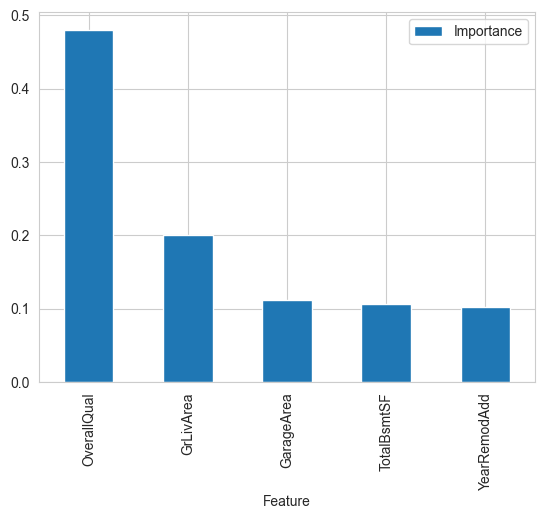

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 7 # Number of steps in the pipeline before feature selection
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


From the chart above, we observe that `OverallQual` dominates in importance, indicating that overall construction and finish quality are the strongest indicator of sale price in Ames, Iowa. This insight could also guide further feature selection or transformation in future iterations.

## Evaluate Regressor on Train and Tests Sets

In [19]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.955
Mean Absolute Error: 10588.573
Mean Squared Error: 279262076.064
Root Mean Squared Error: 16711.136


* Test Set
R2 Score: 0.841
Mean Absolute Error: 19974.215
Mean Squared Error: 1098375372.574
Root Mean Squared Error: 33141.747




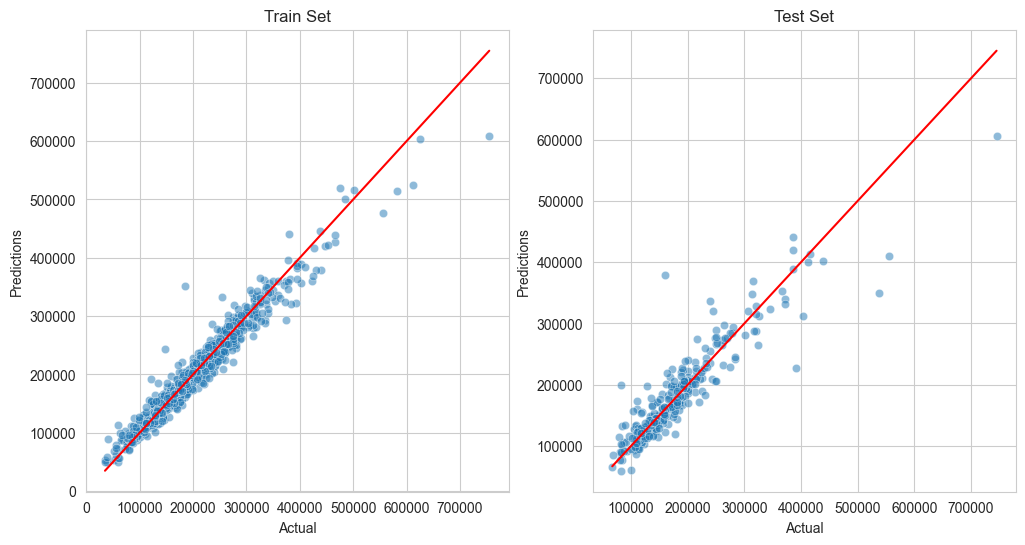

In [20]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

# Refit a Simpler Pipeline with Only Top Features

We rebuild the pipeline using only the most important features to evaluate performance and interpretability trade-offs. This helps simplify the model without sacrificing too much accuracy.


## Rewrite Pipeline

In [21]:
def PipelineOptimization(model):
    yeojohnson_transform = ['TotalBsmtSF','GrLivArea']

    pipeline = Pipeline([
        ("yeojohnson", YeoJohnsonTransformer(variables=yeojohnson_transform)),
        
        ("feat_scaling", StandardScaler()),

        ("model", model),
    ])

    return pipeline

## Split Train Test Set, only with best features

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


### Subset Best Features

We now limit the dataset to only the top 5 most important features (from the previous ExtraTrees model). This lets us test how much performance is retained with fewer predictors.

In [23]:
X_train = X_train[best_features]
X_test = X_test[best_features]

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 5) (1168,) 
* Test set: (292, 5) (292,)


,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearRemodAdd
618,774,1828,9,1822,2007
870,308,894,5,894,1962
92,432,964,5,876,2006


## Grid Search CV – Sklearn

We are using the same model from the previous GridCV search

In [24]:
best_model

'ExtraTreesRegressor'

And we are gonna check for the best parameters just as in the previous GridCV search

In [25]:
best_parameters

{'model__max_depth': 20,
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 5,
 'model__n_estimators': 200}

### Define Hyperparameter Grid for Top 5 Features

This cell defines the hyperparameter grid (`params_top5`) for the `ExtraTreesRegressor` model, which was identified as the best-performing model in the previous grid search.

These hyperparameters will be used in a new grid search to optimize the model's performance when trained on the top 5 most important features. This step ensures that the model is fine-tuned for the reduced feature set.

In [26]:
params_top5 = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
    }
}
params_top5

{'ExtraTreesRegressor': {'model__n_estimators': [100, 200],
  'model__max_depth': [10, 20],
  'model__min_samples_split': [2, 5],
  'model__min_samples_leaf': [1, 2]}}

### Perform Hyperparameter Optimization for Top 5 Features

The results of the grid search will help identify the best hyperparameter configuration for the `ExtraTreesRegressor` model when trained on the reduced feature set.

In [27]:
X_train.head(3)

,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearRemodAdd
618,774,1828,9,1822,2007
870,308,894,5,894,1962
92,432,964,5,876,2006


In [28]:
print("Columns in X_train:", X_train.columns.tolist())


Columns in X_train: ['GarageArea', 'GrLivArea', 'OverallQual', 'TotalBsmtSF', 'YearRemodAdd']


In [29]:
models_top5 = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0)
    }

search = HyperparameterOptimizationSearch(models=models_top5, params=params_top5)
search.fit(X_train, y_train,
                 scoring='r2',
                 n_jobs=-1,
                 cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 16 candidates, totalling 80 fits


View Results and Select Best Pipeline

In [30]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
6,ExtraTreesRegressor,0.75113,0.832113,0.869472,0.044291,10,2,5,100
7,ExtraTreesRegressor,0.750472,0.832091,0.869217,0.044445,10,2,5,200
15,ExtraTreesRegressor,0.751546,0.831548,0.870547,0.044626,20,2,5,200
5,ExtraTreesRegressor,0.745828,0.830478,0.86914,0.045727,10,2,2,200
14,ExtraTreesRegressor,0.749861,0.829732,0.870672,0.045318,20,2,5,100
4,ExtraTreesRegressor,0.744146,0.82899,0.868251,0.045786,10,2,2,100
13,ExtraTreesRegressor,0.747973,0.828631,0.870169,0.045053,20,2,2,200
12,ExtraTreesRegressor,0.748054,0.826665,0.868498,0.044671,20,2,2,100
10,ExtraTreesRegressor,0.712772,0.826232,0.872511,0.05868,20,1,5,100
3,ExtraTreesRegressor,0.716661,0.825307,0.869222,0.056317,10,1,5,200


Check the best model

In [31]:
best_model = grid_search_summary.iloc[0,0]
best_model
best_pipeline_top5 = grid_search_pipelines[best_model].best_estimator_
best_pipeline_top5

Pipeline(steps=[('yeojohnson',
                 YeoJohnsonTransformer(variables=['TotalBsmtSF', 'GrLivArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=10, min_samples_leaf=2,
                                     min_samples_split=5, random_state=0))])

## Assess feature importance

* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'YearRemodAdd']


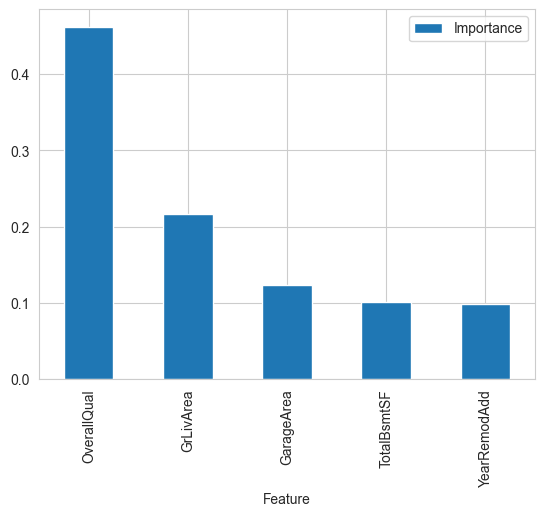

In [41]:
from sklearn.ensemble import ExtraTreesRegressor

# Define the pipeline_selected using the best model
pipeline_selected = PipelineOptimization(ExtraTreesRegressor(
    max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=0))

# Fit the pipeline on the training data
pipeline_selected.fit(X_train, y_train)

# number of data cleaning and feature engineering steps in the pipeline
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_selected.steps[:data_cleaning_feat_eng_steps])
                                        .fit(X_train, y_train)
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': pipeline_selected['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


The importance levels are virtually unchanged in relation to each other.

## Evaluate Classifier on Train and Test Sets

Model Evaluation 

* Train Set
R2 Score: 0.935
Mean Absolute Error: 13565.652
Mean Squared Error: 402589838.852
Root Mean Squared Error: 20064.642


* Test Set
R2 Score: 0.84
Mean Absolute Error: 19830.181
Mean Squared Error: 1107888671.353
Root Mean Squared Error: 33284.962




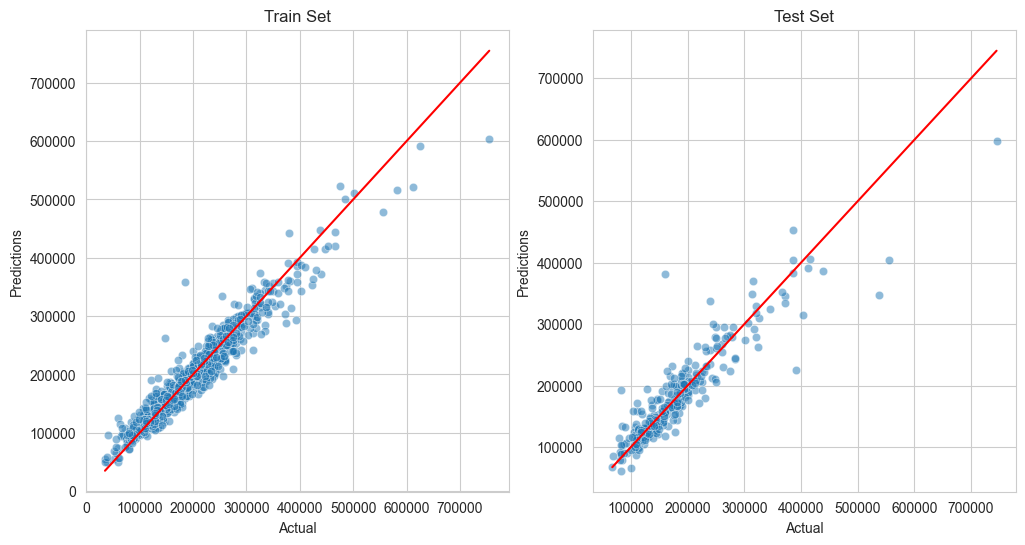

In [33]:
regression_performance(X_train, y_train, X_test, y_test,best_pipeline_top5)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_pipeline_top5)

Although we dropped many features, the model performance remained stable, showing **slight increase in R² Score from 0.84 to 0.844**. This suggests the removed features were not adding significant predictive value, confirming that ExtraTrees is robust and able to focus on strong predictors.

---

# Save Artifacts for Deployment and Dashboard

These outputs will allow the Streamlit app to:

- Load the final trained pipeline
- Access the top 5 features
- Read input format from training data
- Visualize model insights like feature importance

## Create Output Directory

In [42]:
import os
import joblib

version = "v2"
output_dir = f"outputs/ml_pipeline/predict_house_price/{version}"

try:
  os.makedirs(name=output_dir, exist_ok=True)
except Exception as e:
  print(e)

print(f"✅ Output directory created at: {output_dir}")


✅ Output directory created at: outputs/ml_pipeline/predict_house_price/v2


## Save Train and Test Sets

In [43]:
# Save features
X_train.to_csv(f"{output_dir}/X_train.csv", index=False)
X_test.to_csv(f"{output_dir}/X_test.csv", index=False)

# Save targets
y_train.to_csv(f"{output_dir}/y_train.csv", index=False)
y_test.to_csv(f"{output_dir}/y_test.csv", index=False)

print("✅ Train/test sets saved.")

✅ Train/test sets saved.


## Save Final Model Pipeline

In [44]:
joblib.dump(value=best_pipeline_top5, filename=f"{output_dir}/pipeline_top5.pkl")

print("✅ Final model pipeline saved.")

✅ Final model pipeline saved.


## Save Feature Importance Plot

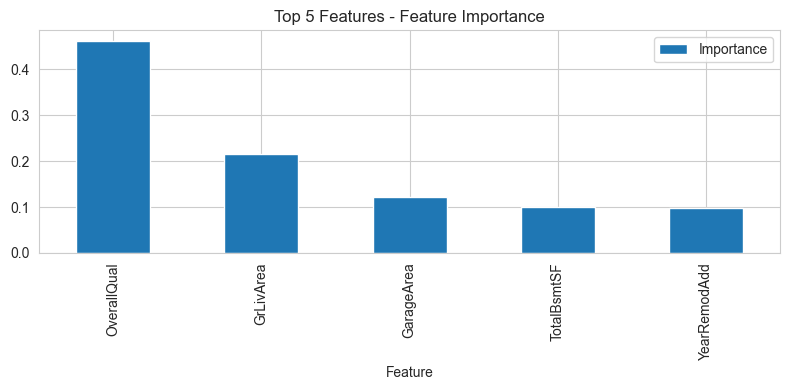

✅ Feature importance plot saved.


In [45]:
# Top 5 features were already used to train the pipeline
df_feature_importance_top5 = df_feature_importance[df_feature_importance["Feature"].isin(X_train.columns)]

df_feature_importance_top5.plot(kind='bar', x='Feature', y='Importance', figsize=(8, 4))
plt.title("Top 5 Features - Feature Importance")
plt.tight_layout()
plt.savefig(f"{output_dir}/feature_importance_top5.png", bbox_inches='tight')
plt.show()

print("✅ Feature importance plot saved.")

## Save Feature List (for dashboard inputs)

In [46]:
joblib.dump(value=list(X_train.columns), filename=f"{output_dir}/feature_list.pkl")

print("✅ Feature list saved for dashboard.")

✅ Feature list saved for dashboard.


## Save evaluation metrics to `.json`

In [47]:
import json

model_metrics = {
    "train": {
        "r2": round(r2_score(y_train, best_pipeline_top5.predict(X_train)), 3),
        "mae": round(mean_absolute_error(y_train, best_pipeline_top5.predict(X_train)), 3),
        "rmse": round(np.sqrt(mean_squared_error(y_train, best_pipeline_top5.predict(X_train))), 3),
    },
    "test": {
        "r2": round(r2_score(y_test, best_pipeline_top5.predict(X_test)), 3),
        "mae": round(mean_absolute_error(y_test, best_pipeline_top5.predict(X_test)), 3),
        "rmse": round(np.sqrt(mean_squared_error(y_test, best_pipeline_top5.predict(X_test))), 3),
    },
    "feature_importance": df_feature_importance.head(5).to_dict(orient="records")
}

output_dir = "outputs/ml_pipeline/predict_house_price/v1"
os.makedirs(output_dir, exist_ok=True)

# Save to JSON file
with open(f"{output_dir}/model_metrics.json", "w") as f:
    json.dump(model_metrics, f, indent=4)

print("✅ Model metrics saved as JSON.")


✅ Model metrics saved as JSON.


## Save scatterplot comparing actual vs. predicted values

In [48]:

import matplotlib.pyplot as plt
import seaborn as sns

def save_regression_plot(X_train, y_train, X_test, y_test, pipeline, output_path, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predicted")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predicted")
    axes[1].set_title("Test Set")

    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()
    print(f"✅ Plot saved to: {output_path}")

# === Save it ===
save_regression_plot(
    X_train, y_train, X_test, y_test,
    pipeline=best_pipeline_top5,
    output_path="outputs/ml_pipeline/predict_house_price/v1/regression_scatterplot.png"
)


✅ Plot saved to: outputs/ml_pipeline/predict_house_price/v1/regression_scatterplot.png
